In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
label_mapping = {
    'climbing': 0,
    'diving': 1,
    'fishing': 2,
    'racing': 3,
    'throwing': 4,
    'pole vaulting': 5
}

In [3]:
def select_random_ints(l_bound, u_bound, quantity):
    return set(random.sample(range(l_bound, u_bound + 1), quantity))

In [4]:
train_dir = './data/train'
test_dir = './data/test'

validation_image_paths = []
validation_image_labels = []
train_image_paths = []
train_image_labels = []
test_image_paths = []
test_image_labels = []

In [5]:
climbing_validation_nums = select_random_ints(0, 325, 65)
diving_validation_nums = select_random_ints(0, 519, 104)
fishing_validation_nums = select_random_ints(0, 162, 32)
racing_validation_nums = select_random_ints(0, 335, 67)
throwing_validation_nums = select_random_ints(0, 316, 63)
vaulting_validation_nums = select_random_ints(0, 278, 55)

for num in climbing_validation_nums:
    filename = 'climbing_' + str(num) + '.jpg'
    image_path = os.path.join(train_dir, filename)
    label = 'climbing'

    validation_image_paths.append(image_path)
    validation_image_labels.append(label_mapping[label])

for num in diving_validation_nums:
    filename = 'diving_' + str(num) + '.jpg'
    image_path = os.path.join(train_dir, filename)
    label = 'diving'

    validation_image_paths.append(image_path)
    validation_image_labels.append(label_mapping[label])

for num in fishing_validation_nums:
    filename = 'fishing_' + str(num) + '.jpg'
    image_path = os.path.join(train_dir, filename)
    label = 'fishing'

    validation_image_paths.append(image_path)
    validation_image_labels.append(label_mapping[label])

for num in racing_validation_nums:
    filename = 'racing_' + str(num) + '.jpg'
    image_path = os.path.join(train_dir, filename)
    label = 'racing'

    validation_image_paths.append(image_path)
    validation_image_labels.append(label_mapping[label])

for num in throwing_validation_nums:
    filename = 'throwing_' + str(num) + '.jpg'
    image_path = os.path.join(train_dir, filename)
    label = 'throwing'

    validation_image_paths.append(image_path)
    validation_image_labels.append(label_mapping[label])

for num in vaulting_validation_nums:
    filename = 'pole vaulting_' + str(num) + '.jpg'
    image_path = os.path.join(train_dir, filename)
    label = 'pole vaulting'

    validation_image_paths.append(image_path)
    validation_image_labels.append(label_mapping[label])

In [6]:
for filename in os.listdir(train_dir):
    image_path = os.path.join(train_dir, filename)
    label = filename.split('_')[0]
    number = int(filename.split('_')[1].split('.')[0])

    if (
        (label == 'climbing' and number not in climbing_validation_nums) or
        (label == 'diving' and number not in diving_validation_nums) or
        (label == 'fishing' and number not in fishing_validation_nums) or
        (label == 'racing' and number not in racing_validation_nums) or
        (label == 'throwing' and number not in throwing_validation_nums) or
        (label == 'pole vaulting' and number not in vaulting_validation_nums)
    ):
        train_image_paths.append(image_path)
        train_image_labels.append(label_mapping[label])

In [7]:
for filename in os.listdir(test_dir):
    image_path = os.path.join(test_dir, filename)
    label = filename.split('_')[0]

    test_image_paths.append(image_path)
    test_image_labels.append(label_mapping[label])

In [8]:
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.404], std=[0.229, 0.224, 0.225])
])

In [9]:
class BARImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.image_labels[idx]
        return image, label

In [10]:
train_dataset = BARImageDataset(train_image_paths, train_image_labels, transformer)
validation_dataset = BARImageDataset(validation_image_paths, validation_image_labels, transformer)
test_dataset = BARImageDataset(test_image_paths, test_image_labels, transformer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = F.relu(out)

        return out

In [12]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [13]:
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer = dict([*model.named_modules()])[target_layer_name]
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        weights = torch.mean(self.gradients, dim=[2, 3])

        weights = weights[:, :, None, None]

        heatmap = torch.sum(weights * self.activations, dim=1).squeeze()

        heatmap = F.relu(heatmap)
        heatmap -= heatmap.min()
        heatmap /= heatmap.max()
        return heatmap.cpu().detach().numpy()


In [14]:
def overlay_heatmap(heatmap, image_path, alpha=0.5):
    original_image = Image.open(image_path).convert("RGB")

    heatmap_resized = Image.fromarray(np.uint8(heatmap * 255)).resize(original_image.size, Image.BILINEAR)

    heatmap_colored = plt.cm.jet(np.array(heatmap_resized) / 255.0)[:, :, :3] * 255
    heatmap_colored = Image.fromarray(np.uint8(heatmap_colored))

    overlayed_image = Image.blend(original_image, heatmap_colored, alpha=alpha)
    return overlayed_image

In [15]:
def generate_and_visualize_heatmap(image_path, model, target_layer_name, class_idx=None):
    model.eval()

    transformer = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.404], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transformer(image).unsqueeze(0).to(device)

    grad_cam = GradCAM(model, target_layer_name)

    outputs = model(input_tensor)
    if class_idx is None:
        class_idx = torch.argmax(outputs, dim=1).item()

    model.zero_grad()
    outputs[0, class_idx].backward()

    heatmap = grad_cam.generate_heatmap(class_idx)

    overlayed_image = overlay_heatmap(heatmap, image_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Heat Map Overlay")
    plt.imshow(overlayed_image)
    plt.axis("off")
    plt.show()

In [16]:
model = ResNet18(num_classes=6)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
auxiliary_position = 2

auxiliary_network = nn.Sequential(
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(256, 6)
).to(device)

auxiliary_optimizer = optim.SGD(auxiliary_network.parameters(), lr=0.001, momentum=0.9)

def forward_with_aux(model, x, aux_position):
    features = model.conv1(x)
    features = model.bn1(features)
    features = model.relu(features)
    features = model.maxpool(features)

    aux_features = None
    for idx, layer in enumerate([model.layer1, model.layer2, model.layer3, model.layer4]):
        features = layer(features)
        if idx == aux_position:
            aux_features = features
    logits = model.avgpool(features)
    logits = torch.flatten(logits, 1)
    logits = model.fc(logits)
    return logits, aux_features

images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
logits, aux_features = forward_with_aux(model, images, auxiliary_position)
print("Main logits shape:", logits.shape)
print("Auxiliary features shape:", aux_features.shape)

Main logits shape: torch.Size([32, 6])
Auxiliary features shape: torch.Size([32, 256, 14, 14])


In [19]:
num_cycles = 10

for cycle in range(num_cycles):
    print(f"\nCycle {cycle+1}/{num_cycles}")

    learning_epochs = 10
    print("Learning Phase")
    for epoch in range(learning_epochs):
        model.train()
        auxiliary_network.train()

        running_loss_main = 0.0
        running_loss_aux = 0.0
        correct_main = 0
        correct_aux = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            logits_main, aux_features = forward_with_aux(model, images, auxiliary_position)
            logits_aux = auxiliary_network(aux_features)

            loss_main = criterion(logits_main, labels)
            loss_aux = criterion(logits_aux, labels)

            optimizer.zero_grad()
            auxiliary_optimizer.zero_grad()

            loss_main.backward(retain_graph=True)
            loss_aux.backward()

            optimizer.step()
            auxiliary_optimizer.step()

            running_loss_main += loss_main.item()
            running_loss_aux += loss_aux.item()

            _, predicted_main = torch.max(logits_main, 1)
            _, predicted_aux = torch.max(logits_aux, 1)

            total += labels.size(0)
            correct_main += (predicted_main == labels).sum().item()
            correct_aux += (predicted_aux == labels).sum().item()

        epoch_loss_main = running_loss_main / len(train_loader)
        epoch_loss_aux = running_loss_aux / len(train_loader)
        epoch_acc_main = 100 * correct_main / total
        epoch_acc_aux = 100 * correct_aux / total

        print(f"Epoch {epoch+1}/{learning_epochs} - Main Loss: {epoch_loss_main:.4f}, Main Accuracy: {epoch_acc_main:.2f}%")
        print(f"Auxiliary Loss: {epoch_loss_aux:.4f}, Auxiliary Accuracy: {epoch_acc_aux:.2f}%")

    if cycle < num_cycles - 1:
        forgetting_epochs = 2
        print("Forgetting Phase")
        for epoch in range(forgetting_epochs):
            model.train()
            for param in auxiliary_network.parameters():
                param.requires_grad = False

            running_loss_forget = 0.0
            total = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                _, aux_features = forward_with_aux(model, images, auxiliary_position)
                logits_aux = auxiliary_network(aux_features)

                uniform_targets = torch.full((images.size(0), 6), 1.0 / 6).to(device)
                forgetting_loss = F.cross_entropy(logits_aux, uniform_targets.argmax(dim=1))

                optimizer.zero_grad()
                forgetting_loss.backward()
                optimizer.step()

                running_loss_forget += forgetting_loss.item()
                total += labels.size(0)

            epoch_loss_forget = running_loss_forget / len(train_loader)
            print(f"Epoch {epoch+1}/{forgetting_epochs} - Forgetting Loss: {epoch_loss_forget:.4f}")


Cycle 1/10
Learning Phase
Epoch 1/10 - Main Loss: 1.2146, Main Accuracy: 54.21%
Auxiliary Loss: 1.3403, Auxiliary Accuracy: 53.05%
Epoch 2/10 - Main Loss: 0.7511, Main Accuracy: 75.18%
Auxiliary Loss: 0.8602, Auxiliary Accuracy: 73.76%
Epoch 3/10 - Main Loss: 0.5701, Main Accuracy: 80.77%
Auxiliary Loss: 0.6812, Auxiliary Accuracy: 79.04%
Epoch 4/10 - Main Loss: 0.5393, Main Accuracy: 82.38%
Auxiliary Loss: 0.6075, Auxiliary Accuracy: 81.35%
Epoch 5/10 - Main Loss: 0.4309, Main Accuracy: 84.69%
Auxiliary Loss: 0.5196, Auxiliary Accuracy: 83.67%
Epoch 6/10 - Main Loss: 0.3928, Main Accuracy: 86.88%
Auxiliary Loss: 0.4802, Auxiliary Accuracy: 84.57%
Epoch 7/10 - Main Loss: 0.3700, Main Accuracy: 87.59%
Auxiliary Loss: 0.4448, Auxiliary Accuracy: 86.24%
Epoch 8/10 - Main Loss: 0.3280, Main Accuracy: 89.00%
Auxiliary Loss: 0.4157, Auxiliary Accuracy: 86.82%
Epoch 9/10 - Main Loss: 0.2970, Main Accuracy: 89.58%
Auxiliary Loss: 0.3898, Auxiliary Accuracy: 87.85%
Epoch 10/10 - Main Loss: 0.2

Loss = `[1.2146, 0.7511, 0.5701, 0.5393, 0.4309, 0.3928, 0.3700, 0.3280, 0.2970, 0.2612, 0.8522, 0.3799, 0.2706, 0.2430, 0.2497, 0.1846, 0.1716, 0.1115, 0.1060, 0.0774, 0.5538, 0.1620, 0.1287, 0.0850, 0.0915, 0.0548, 0.0617, 0.0414, 0.0320, 0.0249, 0.4620, 0.1149, 0.0813, 0.0367, 0.0251, 0.0183, 0.0243, 0.0166, 0.0133, 0.0090, 0.4118, 0.0924, 0.0288, 0.0251, 0.0049, 0.0062, 0.0153, 0.0077, 0.0062, 0.0091, 0.3645, 0.0776, 0.0179, 0.0062, 0.0065, 0.0031, 0.0093, 0.0159, 0.0023, 0.0035, 0.4949, 0.0545, 0.0205, 0.0051, 0.0053, 0.0029, 0.0028, 0.0044, 0.0043, 0.0011, 0.3421, 0.0544, 0.0214, 0.0087, 0.0040, 0.0017, 0.0023, 0.0029, 0.0018, 0.0023, 0.2911, 0.0182, 0.0041, 0.0059, 0.0037, 0.0037, 0.0012, 0.0010, 0.0007, 0.0007, 0.2462, 0.0313, 0.0148, 0.0042, 0.0012, 0.0015, 0.0008, 0.0006, 0.0005, 0.0003]`

In [20]:
model.eval()

val_running_loss = 0.0
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        val_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

val_loss = val_running_loss / len(validation_loader)
val_acc = 100 * val_correct / val_total

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

Validation Loss: 0.4090, Validation Accuracy: 90.41%


In [21]:
model.eval()

test_running_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss = test_running_loss / len(test_loader)
test_acc = 100 * test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 4.4774, Test Accuracy: 32.87%


/Users/anmolrao/Code/SiFeR/sifer_venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


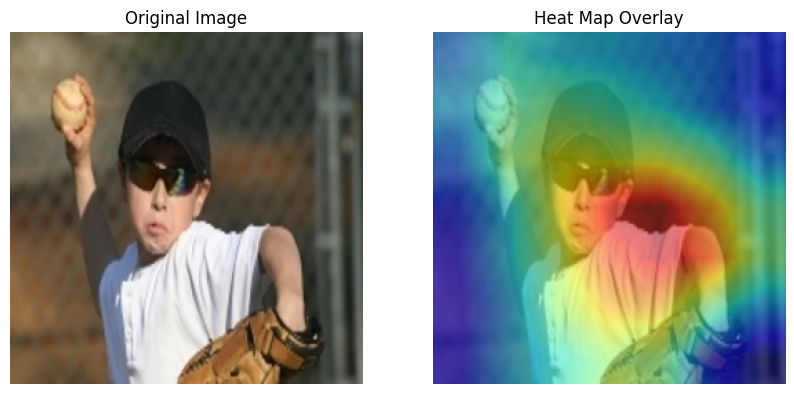

In [22]:
image_path = './data/test/throwing_321.jpg'
target_layer_name = 'layer4'
generate_and_visualize_heatmap(image_path, model, target_layer_name)